In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow_addons as tfa
import time
from keras import regularizers



C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201205). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:
#Kode til at kører på gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
#Finder datasættets placering
import pathlib
data = r"C:\Users\tobia\Samlet CNN\data"
data_dir = pathlib.Path(data)
type(data_dir)


pathlib.WindowsPath

In [4]:
#Kontrollere om der ligger billeder på placer
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

35887


In [5]:
#Laver et tensorflow dataset med stier til vores data, for både vores trænnings- og validerings data
#Train
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Val
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'), shuffle=False)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
type(train_ds)

28709
3589


tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [6]:
#Ser om vi data'en er importeret korrekt
for f in train_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\Happy\\3760.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\Fear\\9854.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\Surprise\\19424.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\Surprise\\17280.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\Surprise\\4099.png'


In [7]:
#Laver en liste over de forskellige kategorier
class_names = np.array(sorted([item.name for item in data_dir.glob('train/*')]))
print(class_names)

['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [8]:
batch_size = 64
img_height = 48
img_width = 48

In [9]:
#Viser et billede før og efter augmentation
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original.numpy().astype("uint8"),cmap='gray')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented.numpy().astype("uint8"),cmap='gray')

In [10]:
def get_label(file_path):
  #Splitter en sti ved brug af en 'path seperator'. Laver en liste af 'path components'
  parts = tf.strings.split(file_path, os.path.sep)
  #Tager den næst sidste i vores liste som svarer til vores klasses fil placeringen
  one_hot = parts[-2] == class_names
  #Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def decode_img(img):
  #Konvertere til uint8 tensor = Defaults to tf.uint8.
  img = tf.image.decode_png(img, channels=1)
  #Ændre størrelse på vores billede
  return tf.image.resize(img, [img_height, img_width])

In [12]:
#Denne funktion bruger de to overstående funktioner
def process_path(file_path):
    label = get_label(file_path)
  #Loader vores data
    img = tf.io.read_file(file_path)
    img = decode_img(img)
  #Return billede med et tilhørende label
    return img, label

In [13]:
# Ved brug af .map, så bruges funktionen process_path på alle elementerne i vores datasets.
# Load/process billederne parallelt med num_parallel_calls
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (48, 48, 1)
Label:  3


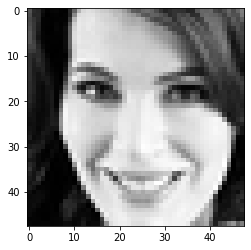

In [14]:
#Vis et billede fra træningsdataen med det tilhørende label
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"),cmap='gray')
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [15]:
#Her rescaler vi og gør så alle billeder har samme størrelse 
def resize_and_rescale(image, label):
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image/ 255.0)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label


In [16]:
#kode hvor alt augment sker
def augment(image,label):
    random_number = random.uniform(0.1,0.8)
    random_number_flip = random.uniform(0,2)
    image, label = resize_and_rescale(image, label)
    
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 1])
    
    #shear
    random_number_shear = random.uniform(-0.3,0.3)
    shear = random_number_shear
    shear_rotate = shear * -20
    image = tfa.image.transform(image, [1.0, shear, shear_rotate, 0.0, 1.0, 0.0, 0.0, 0.0])

    #distortion
    random_number_distortion = random.uniform(0,5)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=random_number_distortion, dtype=tf.float32)
    image = tf.add(image, noise)
        
    #Flip    
    if random_number_flip > 1:
        image = tf.image.flip_left_right(image)
    # Random brightness       
    image = tf.image.random_brightness(image, max_delta=0.5) 
    return image, label

In [17]:
#Her rescaler og resizer vi vores trænings- og validerings data. Deler dem ind i batches og blander dem
print(train_ds)    
train_ds = (
    train_ds
    .shuffle(1000)
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)    
#Gemmer en kopi af train_ds så vi har en ikke augmentered version.
orgDataset = train_ds
print(train_ds)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

<ParallelMapDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 48, 48, 1), (None,)), types: (tf.float32, tf.int64)>


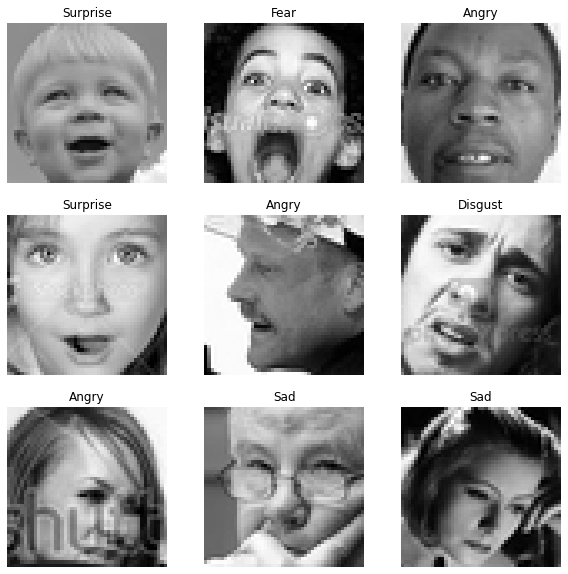

In [18]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")


In [19]:
#Exempler på data augmentation
def flipImage(image):
    flipped = tf.image.flip_left_right(image)
    return flipped
def brightnessImage(image):
    image = tf.image.adjust_brightness(image,0.5)
    return image

tensorflow.python.framework.ops.EagerTensor

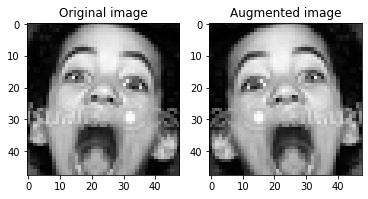

In [20]:
#Kontrol om vores data augmentation virker
image = image_batch[1]
flipped = flipImage(image)
visualize(image,flipped)
type(image)

In [21]:
#I model_checkpoint gemmer vi den bedste val_accuracy vi får under vores træning
class CustomCallback(keras.callbacks.Callback):
   
    def on_epoch_end(self, epoch, logs=None):      
        image_batch, label_batch = next(iter(train_ds))
        plt.figure(figsize=(10, 10))
        for i in range(1):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
            label = label_batch[i]
            plt.title(class_names[label])
            plt.axis("off")
            
checkpoint_filepath = r'C:\Users\tobia\Samlet CNN\save models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
from tensorflow.keras import layers

#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 7
cnn = tf.keras.models.Sequential([
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Flatten(),
layers.Dense(units=128, activation='relu'),
layers.Dense(units=7,activation='softmax')
])

cnn.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])



In [23]:
#Vi laver vores CNN model og compiler den
from tensorflow.keras import layers



num_classes = 7
model = tf.keras.models.Sequential([
layers.experimental.preprocessing.Resizing(48, 48),
layers.experimental.preprocessing.Rescaling(1./255),
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(units=256, activation='relu'),
layers.Dense(units=7,activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])


1/1
449/449 [==============================] - 13s 21ms/step - loss: 1.7555 - accuracy: 0.2822 - val_loss: 1.4498 - val_accuracy: 0.4469
It took 0:0:14
highest_accuracy: 0.3387787938117981 highest_val_accuracy (Epoch: 1) : 0.44692113995552063 lowest_loss: 1.6568255424499512 lowest_val_loss: 1.4497770071029663


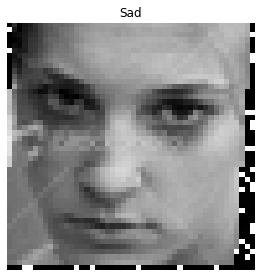

In [24]:
#Laver variabler og lister for at kunne visualisere udviklingen
n_epoch = 1
best_epoch = 0

last_25_accuracy = []
accuracy = []
highest_accuracy = 0

last_25_val_accuracy = []
val_accuracy = []
highest_val_accuracy = 0

last_25_loss_ = []
loss_ = []
lowest_loss_ = 100

last_25_val_loss = []
val_loss = []
lowest_val_loss = 100
#callbacks=[model_checkpoint_callback])

#Træner vores model i et forloop en epoch af gangen
start = time.time()
for i in range(n_epoch):
    try:
        print(f"{i+1}/{n_epoch}")
        history = model.fit(train_ds, validation_data = val_ds, epochs = 1)
        #Vi unbatcher og blander dataen
        #Derefter augmenterer vi på vores oprindelige dataset (ikke augmenteret). Batcher igen til sidst.
        train_ds = (
            orgDataset
            .unbatch()
            .shuffle(1000)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
         )
        
        #if statemen som gemmer de værdier nænvt øvest
        if highest_accuracy < history.history['accuracy'][0]:
            highest_accuracy = history.history['accuracy'][0]
            
        if highest_val_accuracy < history.history['val_accuracy'][0]:
            highest_val_accuracy = history.history['val_accuracy'][0]
            best_epoch = i+1
            
        if lowest_loss_ > history.history['loss'][0]:
            lowest_loss_ = history.history['loss'][0]
            
        if lowest_val_loss > history.history['val_loss'][0]:
            lowest_val_loss = history.history['val_loss'][0]       
            
            
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        loss_.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        
        #Gemmer de sidste 25
        if i>=75:
            last_25_accuracy.append(history.history['accuracy'])
            last_25_val_accuracy.append(history.history['val_accuracy'])
            last_25_loss_.append(history.history['loss'])
            last_25_val_loss.append(history.history['val_loss'])
            
        #Viser hver 1 billede hver 5. epoch da der er cap på 20
        if i%5 == 0:
            image_batch, label_batch = next(iter(train_ds))
            plt.figure(figsize=(10, 10))
            for i in range(1):
                ax = plt.subplot(2, 2, i + 1)
                plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
                label = label_batch[i]
                plt.title(class_names[label])
                plt.axis("off")
    except ValueError:
        print(train_ds)
end = time.time()
duration = end - start
p1 = int(duration % 60)
p2 = int(duration / 60)
p3 = int(p2 % 60)
p2 = int(p2 / 60)
print(f"It took {p2}:{p3}:{p1}")
print(f"highest_accuracy: {highest_accuracy} highest_val_accuracy (Epoch: {best_epoch}) : {highest_val_accuracy} lowest_loss: {lowest_loss_} lowest_val_loss: {lowest_val_loss}")

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)       

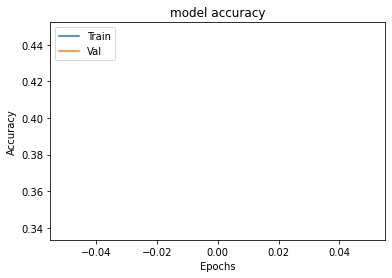

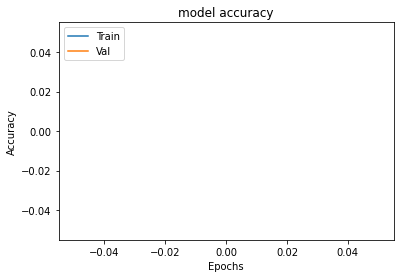

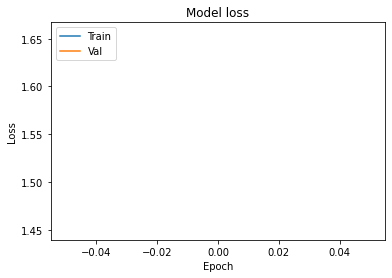

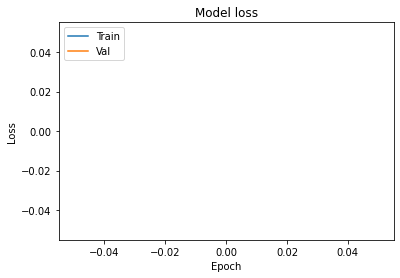

In [32]:
#Plotter de værdi vi gemte i forrige celle
#accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('graph1.png')
plt.show()

#accuracy sidste 25
plt.plot(last_25_accuracy)
plt.plot(last_25_val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('graph11.png')
plt.show()

#loss
plt.plot(loss_)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('graph2.png')
plt.show()

#loss sidste 25
plt.plot(last_25_loss_)
plt.plot(last_25_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('graph22.png')
plt.show()


<PIL.Image.Image image mode=RGB size=48x48 at 0x29D07BF3430>


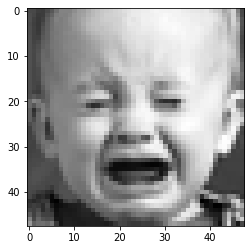

In [37]:
#Henter et testbillede og gør det gråt
import numpy as np
from keras.preprocessing import image
from PIL import Image, ImageOps 
test_image = image.load_img(r'C:\Users\tobia\Samlet CNN\data\test\sad\32869.png', target_size = (48, 48))
print(test_image)
test_image = ImageOps.grayscale(test_image) 
plt.imshow(test_image,cmap='gray')



[[[[ 65.]
   [ 64.]
   [ 55.]
   ...
   [186.]
   [113.]
   [ 63.]]

  [[ 68.]
   [ 62.]
   [ 52.]
   ...
   [184.]
   [126.]
   [ 65.]]

  [[ 69.]
   [ 59.]
   [ 50.]
   ...
   [187.]
   [142.]
   [ 74.]]

  ...

  [[ 82.]
   [ 57.]
   [ 76.]
   ...
   [115.]
   [176.]
   [118.]]

  [[114.]
   [ 63.]
   [ 90.]
   ...
   [ 70.]
   [147.]
   [181.]]

  [[135.]
   [ 87.]
   [ 97.]
   ...
   [ 65.]
   [ 21.]
   [ 63.]]]]
[0.14332491159439087, 0.018070075660943985, 0.0932333841919899, 0.5460756421089172, 0.02255501225590706, 0.07758794724941254, 0.09915303438901901]


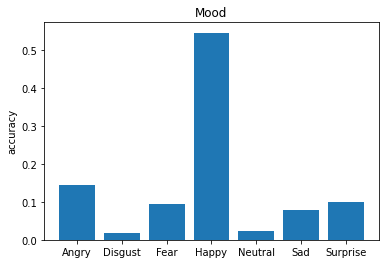

In [38]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
result = result.tolist()
result = result[0]
print(result)
plt.title('Mood')
plt.ylabel('accuracy')
plt.bar(class_names, result)
plt.savefig('barGraph.png')
plt.show()


In [29]:
print(history.history['accuracy'])

[0.3387787938117981]


In [30]:
import itertools
from sklearn.metrics import confusion_matrix

In [31]:
unbatched_val_ds = val_ds.unbatch()
print(unbatched_val_ds)
y = []
for label in unbatched_val_ds:
    y.append(label)

pred = model.predict(val_ds)
pred = np.argmax(pred, axis=1)
print(pred)
conf = confusion_matrix(y, pred)


import seaborn as sns
sns.heatmap(conf, annot=True)

<_UnbatchDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>
[3 4 3 ... 3 3 3]


C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()